# PhysRevA.100.022122

Enhanced pair production in collisions of intense pulsed lasers with a high-energy electron beam

Heng-Yu Zhang _et al_, Phys. Rev. A __100__, 022122 

https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.022122

Results (partially) reproduced by Ó. Amaro, November 2022

In [1]:
import numpy as np
from numpy import pi, sin, cos, log, exp, arccos, sqrt
import matplotlib.pyplot as plt
# physical constants
from scipy.constants import speed_of_light, hbar, elementary_charge, electron_mass
from scipy.interpolate import interp1d
from scipy.integrate import quad
from tqdm import tqdm
rng = np.random.default_rng()
from scipy import optimize

The Compton differential cross section is given by equation 1 

$\dfrac{d\sigma}{d\theta} = 2\pi \sin \theta \dfrac{r_0^2}{2} \left( \dfrac{\varepsilon_2}{\varepsilon_1} \right)^2 \left[ \dfrac{\varepsilon_2}{\varepsilon_1} + \dfrac{\varepsilon_1}{\varepsilon_2} - \sin^2 \theta \right]$

where $\varepsilon_1$ is the energy of the incident photon and $\varepsilon_2=\varepsilon_1/[1+(1-\cos \theta)\varepsilon_1/m]$ is the energy of the final photon.

In [2]:
# main parameters
Nsmpl = int(1e6)  # sampling resolution
nbins = 100 #[] number of histogram bins

# beam
m = 0.5109989461/1000; #[GeV] electron mass
E0 = 46.6; #[GeV]
g0 = E0*1e9*elementary_charge/(electron_mass*speed_of_light**2); #[] 91193
beta0 = sqrt(1-1/g0**2)**2 #[] 

eps1 = 0.428e-3; #[GeV]
thdim = 100; #[]
enedim = 20; #[]
r0 = 2.8179e-15; #[m] elementary_charge**2 / (4*pi*electron_mass) #

# FIG.1 (a)
# theory
def eps2_of_th(th):
    """ energy of outgoing photon as function of ingoing and emission angle """
    return eps1/(1+(1-cos(th))*eps1/m);

def th_of_eps2(eps2):
    """ inverse function of eps2_of_th """
    return arccos(1 + m*(1/eps1-1/eps2));

def dsdth_nCS(th):
    """ eq 1 nCS cross section """
    eps2 = eps2_of_th(th)
    return 2*pi * sin(th) * r0**2/2 * (eps2/eps1)**2 * ( eps1/eps2 + eps2/eps1 - sin(th)**2 );

# PDF
thlst = np.linspace(0.0001,0.9999*pi,nbins);
Ithlst = np.linspace(0.00001, 0.99999,nbins)
dsdth_nCS_PDF = np.array([dsdth_nCS(th) for th in thlst]);
dsdth_nCS_PDF_max = np.max(dsdth_nCS_PDF)

# CDF
dsdth_nCS_CDF = np.cumsum(dsdth_nCS_PDF)
dsdth_nCS_CDF = dsdth_nCS_CDF/np.max(dsdth_nCS_CDF)
dsdth_nCS_CDFfun = interp1d(thlst, dsdth_nCS_CDF)

# ICDF
def dsdth_nCS_ICDFaux(y, x): return dsdth_nCS_CDFfun(y) - x # function of which to find root
def dsdth_nCS_ICDFfun(x): return optimize.bisect(dsdth_nCS_ICDFaux, 0.0001, 0.9999*pi, args=(x)) # invert CDF, find root of aux function
dsdth_nCS_ICDF = np.array([ dsdth_nCS_ICDFfun(x) for x in Ithlst])
dsdth_nCS_ICDFfun_interp = interp1d(Ithlst, dsdth_nCS_ICDF)
#print( dsdth_nCS_ICDFfun_interp(9e-1) )
"""
plt.plot(thlst, dsdth_nCS_ICDFaux(thlst,0.9))
plt.plot(thlst, thlst*0)
plt.show()
"""
# uniform distribution
usmpl = (1-4e-4)*rng.random(Nsmpl)+2e-4
dsdth_nCS_ICDFsmpl = np.array([ dsdth_nCS_ICDFfun_interp(usmpl[x]) for x in tqdm(range(Nsmpl))])

100%|██████████| 1000000/1000000 [00:46<00:00, 21706.41it/s]


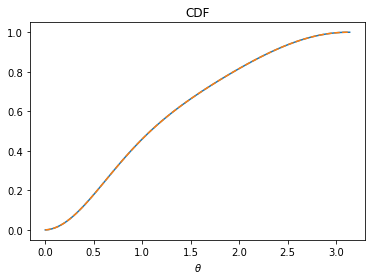

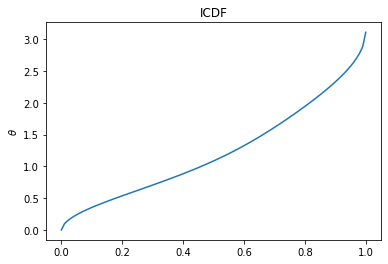

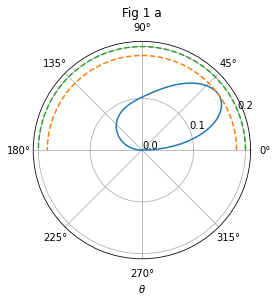

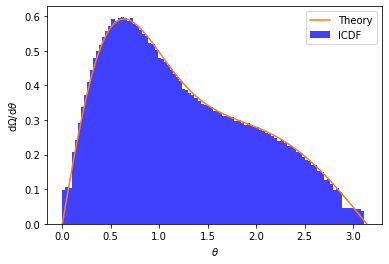

In [3]:
plt.plot(thlst, dsdth_nCS_CDF, label=r'Theory')
plt.plot(thlst, dsdth_nCS_CDFfun(thlst), '--', label=r'Interpolate')
plt.title(r'CDF')
plt.xlabel(r'$\theta$')
plt.show()

plt.plot(Ithlst, dsdth_nCS_ICDF)
plt.title(r'ICDF')
plt.ylabel(r'$\theta$')
plt.show()

# multiply by 1e28 (barn), as in caption of figure 1 a
plt.polar(thlst, dsdth_nCS_PDF*1e28)
plt.polar(thlst, dsdth_nCS_PDF*0 + dsdth_nCS_PDF_max*1e28, '--')
plt.polar(thlst, dsdth_nCS_PDF*0 + 0.2, '--')
plt.xlabel(r'$\theta$')
plt.yticks([0,0.1,0.2])
plt.title(r'Fig 1 a')
plt.show()

hist_ICDF_y, hist_ICDF_x, _ = plt.hist(dsdth_nCS_ICDFsmpl, thlst, density=True, facecolor='b', alpha=0.75, label=r'ICDF')
plt.plot(thlst, dsdth_nCS_PDF/np.trapz(dsdth_nCS_PDF,thlst)*np.trapz(hist_ICDF_y, hist_ICDF_x[:-1]), label=r'Theory')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mathrm{d}\Omega/\mathrm{d}\theta$')
plt.legend()
plt.show()

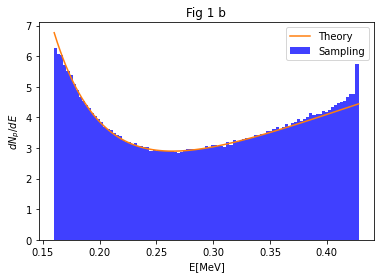

0.4279992608897607


In [17]:
eps2_smpl = np.array([eps2_of_th(th) for th in dsdth_nCS_ICDFsmpl])
eps2_lst = np.linspace(np.min(eps2_smpl),np.max(eps2_smpl),thdim);            
eps2_PDF = np.array([dsdth_nCS(th_of_eps2(eps2)) * (m/sqrt(1-(1+m*(1/eps1-1/eps2))**2)/eps2**2) for eps2 in eps2_lst])

hist_ICDF_y, hist_ICDF_x, _ = plt.hist(eps2_smpl*1e3, eps2_lst*1e3, density=True, facecolor='b', alpha=0.75, label=r'Sampling')
plt.plot(eps2_lst*1e3, eps2_PDF/np.trapz(eps2_PDF,eps2_lst*1e3)*np.trapz(hist_ICDF_y,hist_ICDF_x[:-1]), label=r'Theory')
plt.xlabel(r'E[MeV]')
plt.ylabel(r'$dN_p/dE$')
plt.legend()
plt.title(r'Fig 1 b')
plt.show()

# max = 0.43 MeV, eps2_smpl[GeV]
print(np.max(eps2_smpl)*1e3)

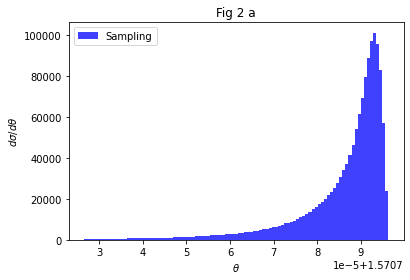

In [18]:
# Lorentz transformation of angle to lab frame
th_lab = pi/2 - np.arctan(1/g0 * (sin(dsdth_nCS_ICDFsmpl))/(beta0 + cos(dsdth_nCS_ICDFsmpl)) )

def th_lab_fun(th):
    # th_lab as function of th_CM
    return pi/2 - np.arctan(1/g0 * (sin(th))/(beta0 + cos(th)) )

def th_of_th_lab(th_lab):
    # inverse boost: th_CM as function of th_lab
    return

def th_lab_fun_der(th):
    "derivative"
    dth = 1e-3
    return (th_lab_fun(th+dth)-th_lab_fun(th-dth))/(2*dth)

plt.hist(th_lab, np.linspace(179.992,180,thdim)/180*pi/2, density=True, facecolor='b', alpha=0.75, label=r'Sampling')
plt.title(r'Fig 2 a')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$d\sigma/d\theta$')
plt.show()

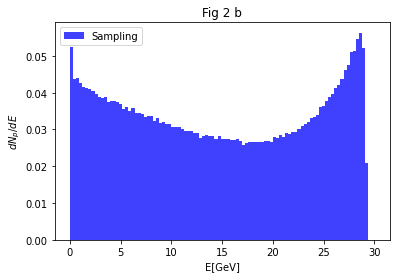

In [19]:
#[GeV]
# Lorentz transformation of energy to lab frame
eps2_smpl_lab = g0 * ( eps2_smpl - beta0 * eps2_smpl * cos(dsdth_nCS_ICDFsmpl) )
         
hist_ICDF_y, hist_ICDF_x, _ = plt.hist(eps2_smpl_lab, np.linspace(0,30,thdim), density=True, facecolor='b', alpha=0.75, label=r'Sampling')
plt.xlabel(r'E[GeV]')
plt.ylabel(r'$dN_p/dE$')
plt.legend()
plt.title(r'Fig 2 b')
plt.show()